In this workflow, we show how to filter WSI tiles. This is recommended before applying segmentation to the WSI, to not segment redundant regions of the slide.

We will be using test WSIs from [https://openslide.cs.cmu.edu/download/openslide-testdata/](https://openslide.cs.cmu.edu/download/openslide-testdata/) in this workflow.

In [1]:
from platform import python_version

print("python version:", python_version())

python version: 3.12.3


In [2]:
from histolytics.wsi.slide_reader import SlideReader
from pathlib import Path

in_dir = Path().home() / "openslide_test"
slide = in_dir / "CMU-1-JP2K-33005.svs"
reader = SlideReader(slide, backend="CUCIM")

## Tissue Mask Generation

The `get_tissue_mask` method of the `SlideReader` class is used to automatically identify tissue regions within a whole slide image. This method applies Otsu thresholding to distinguish tissue from the background, producing a binary mask (`tissue_mask`). The threshold value (`thresh`) used for segmentation is also returned.

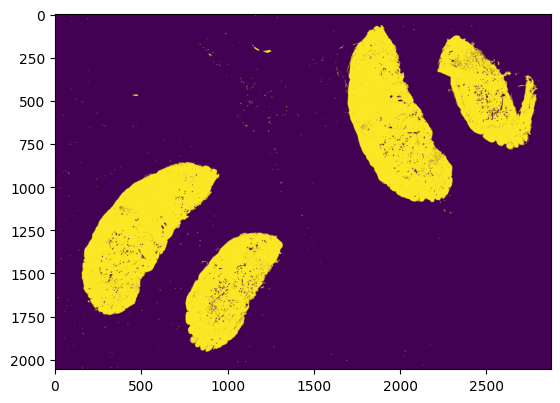

In [3]:
import matplotlib.pyplot as plt

# Get the tissue mask and coordinates
thresh, tissue_mask = reader.get_tissue_mask(level=-1)
coordinates = reader.get_tile_coordinates(width=1024, tissue_mask=tissue_mask)

plt.imshow(tissue_mask)

## Connected components based tile-grid selection

Sometimes WSI slides contain multiple tissue regions, and we want to focus on only some of these areas for further analysis. The `get_sub_grids` function can be used to group spatially contiguous tiles into sub-grids, representing distinct tissue regions within the slide. The `get_sub_grids` function takes the tile coordinates and identifies these connected regions. To focus on substantial tissue areas, we filter out sub-grids with fewer than 50 tiles.

The `filtered_sub_grids` variable contains a list of spatially contiguous tile groups, each representing a distinct tissue region within the slide. The sub-grids are ordered by their minimum y-coordinate, meaning the first sub-grid in the list corresponds to the tissue region closest to the top of the slide (with the origin at the top-left corner).

In [4]:
from histolytics.wsi.utils import get_sub_grids


# Get the contiguous sub-grids
sub_grids = get_sub_grids(coordinates)
filtered_sub_grids = [grid for grid in sub_grids if len(grid) > 50]

Visualize the first sub-grid

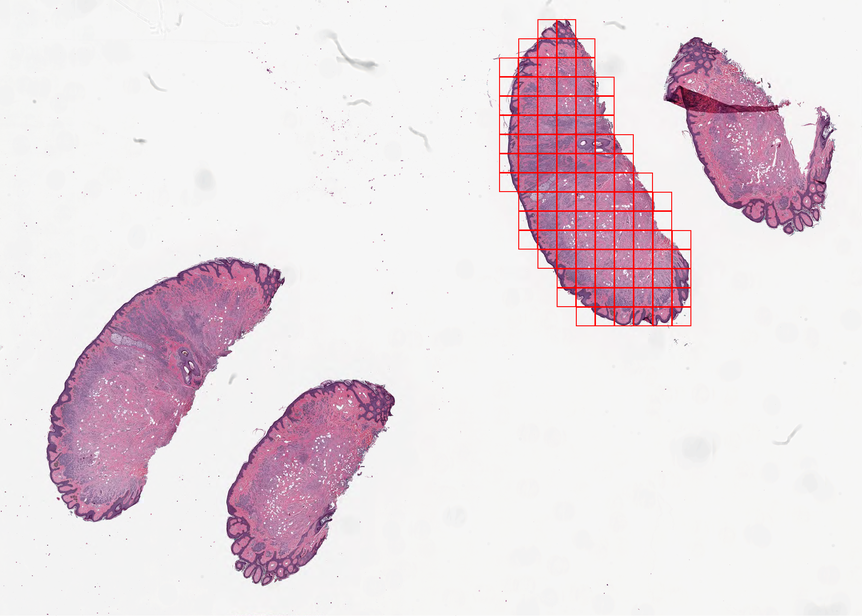

In [5]:
from PIL import Image


#  helper downsampling function for visualization
def downsample_thumbnail(annotated_thumbnail, scale_factor=0.3):
    new_width = int(annotated_thumbnail.width * scale_factor)
    new_height = int(annotated_thumbnail.height * scale_factor)
    return annotated_thumbnail.resize((new_width, new_height), Image.LANCZOS)


# pick the first sub-grid
sub_coords = filtered_sub_grids[0]

thumbnail = reader.read_level(-1)
anno_thumb = reader.get_annotated_thumbnail(thumbnail, sub_coords, linewidth=3)
downsample_thumbnail(anno_thumb)

Visualize the third sub-grid

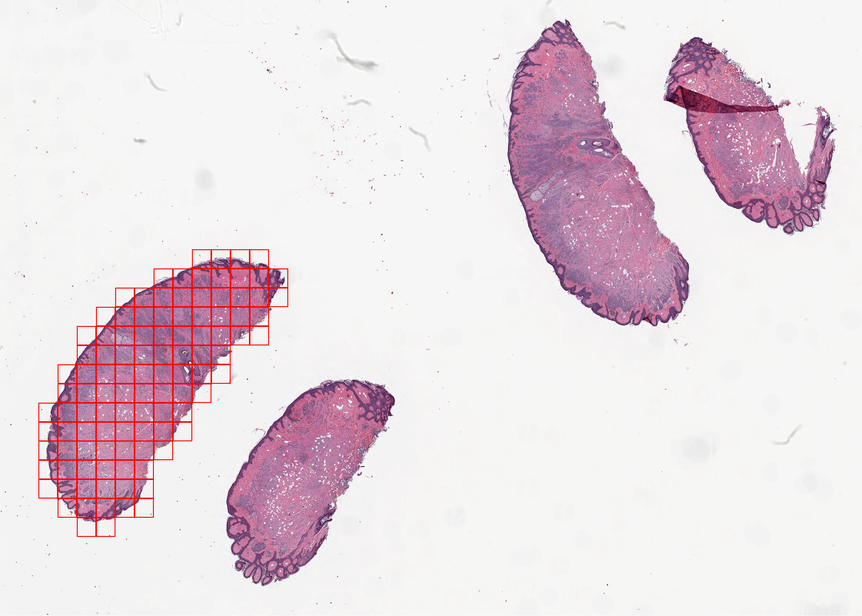

In [6]:
# pick the first sub-grid
sub_coords = filtered_sub_grids[2]

thumbnail = reader.read_level(-1)
reader.get_annotated_thumbnail(thumbnail, sub_coords, linewidth=3)

anno_thumb = reader.get_annotated_thumbnail(thumbnail, sub_coords, linewidth=3)
downsample_thumbnail(anno_thumb)

## Adjusting threshold

Sometimes the tissue masking with Otsu threshold has to be adjusted, for example, when the tissue contains fat tissue which will be mistaken as background if the threshold is not set correctly.

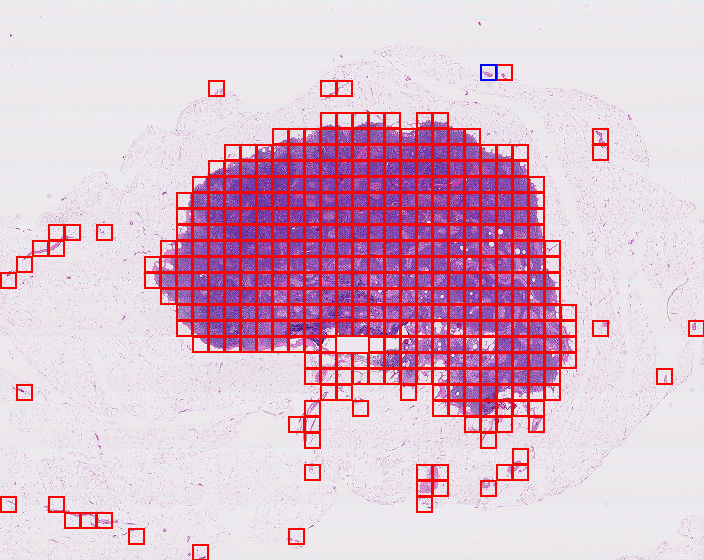

In [7]:
slide = in_dir / "Philips-1.tiff"
reader = SlideReader(slide, backend="CUCIM")

thresh, tissue_mask = reader.get_tissue_mask(level=-2)
coordinates = reader.get_tile_coordinates(width=1024, tissue_mask=tissue_mask)

thumbnail = reader.read_level(-2)
anno_thumb = reader.get_annotated_thumbnail(thumbnail, coordinates, linewidth=2)
anno_thumb

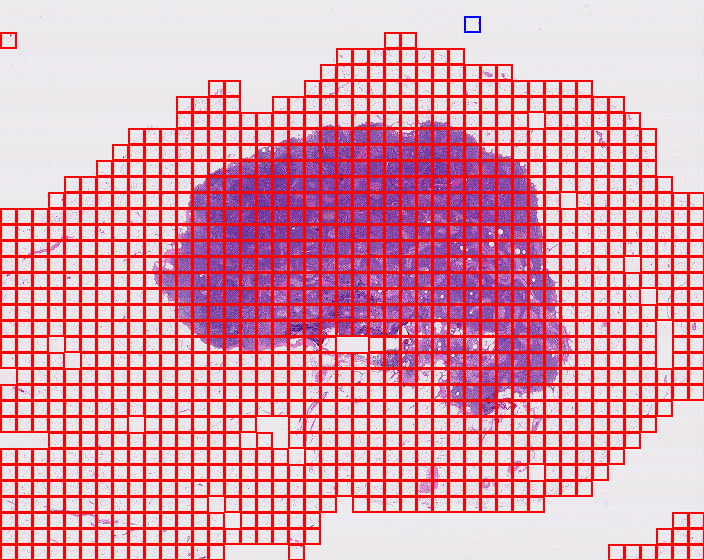

In [8]:
thresh, tissue_mask = reader.get_tissue_mask(level=-2, threshold=225)
coordinates = reader.get_tile_coordinates(width=1024, tissue_mask=tissue_mask)

thumbnail = reader.read_level(-2)
anno_thumb = reader.get_annotated_thumbnail(thumbnail, coordinates, linewidth=2)
anno_thumb

## Selecting tiles by annotations

In cases where tissue masking is not sufficient, you can select tiles by providing pre-defined annotations which are used to filter tiles.

In [9]:
from shapely.geometry import box

bbox = box(15000, 12000, 25000, 22000)

coordinates = reader.get_tile_coordinates(
    width=1024, tissue_mask=None, annotations=bbox
)

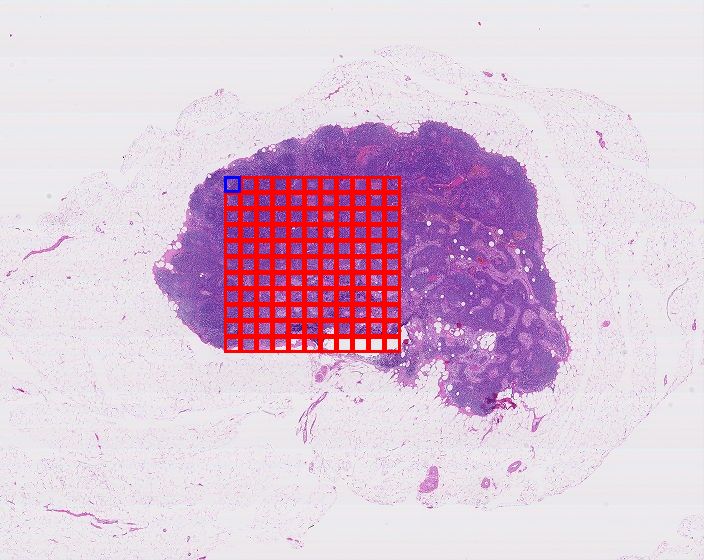

In [10]:
reader.get_annotated_thumbnail(thumbnail, coordinates, linewidth=3)